
# K-Means Clustering Workflow — EDA → Model → Interpretasi → Ekspor

## 1) Informasi Dataset dan Fitur Utama
> Isi ringkasan ini sesuai dataset yang Anda gunakan.
- **Sumber dataset**: (contoh: Spotify audio features / transaksi / dsb.)
- **Tujuan analisis**: (contoh: menemukan arketipe/mood lagu, segmen pelanggan, dll.)
- **Fitur utama yang digunakan**: sebutkan fitur numerik & kategorikal yang relevan
- **Target jumlah klaster (perkiraan)**: (opsional, mis. 6–12)


## 2) Import Library

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

try:
    from yellowbrick.cluster import KElbowVisualizer
    _YB_OK = True
except Exception as e:
    print("Yellowbrick (KElbowVisualizer) tidak tersedia. Akan pakai elbow manual.")
    _YB_OK = False

import joblib
from pathlib import Path
from collections import defaultdict

RANDOM_STATE = 42
plt.rcParams.update({'figure.figsize': (7,5)})
print("Libraries imported.")


Libraries imported.



## 3) Memuat Dataset
1) `head()`  
2) `info()`  
3) `describe()`


In [4]:

DATA_PATH = Path("data/tracks_features.csv")  # Ganti dengan file Anda
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

print("\nINFO DATASET:")
df.info()

print("\nDESKRIPSI NUMERIK:")
display(df.describe(include=[np.number]).T)

print("\nDESKRIPSI KATEGORIKAL (top 5):")
for col in df.select_dtypes(include=['object','category']).columns[:10]:
    print(f"- {col}:")
    display(df[col].value_counts().head(5))


Shape: (1204025, 24)


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02



INFO DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204025 non-null  object 
 1   name              1204022 non-null  object 
 2   album             1204014 non-null  object 
 3   album_id          1204025 non-null  object 
 4   artists           1204025 non-null  object 
 5   artist_ids        1204025 non-null  object 
 6   track_number      1204025 non-null  int64  
 7   disc_number       1204025 non-null  int64  
 8   explicit          1204025 non-null  bool   
 9   danceability      1204025 non-null  float64
 10  energy            1204025 non-null  float64
 11  key               1204025 non-null  int64  
 12  loudness          1204025 non-null  float64
 13  mode              1204025 non-null  int64  
 14  speechiness       1204025 non-null  float64
 15  acousticness      1204025 non-null

,count,mean,std,min,25%,50%,75%,max
track_number,1204025.0,7.656352,5.994977,1.0,3.000000,7.00000,10.0000,50.000
disc_number,1204025.0,1.055906,0.295375,1.0,1.000000,1.00000,1.0000,13.000
danceability,1204025.0,0.493057,0.189669,0.0,0.356000,0.50100,0.6330,1.000
energy,1204025.0,0.509536,0.294684,0.0,0.252000,0.52400,0.7660,1.000
key,1204025.0,5.194151,3.536731,0.0,2.000000,5.00000,8.0000,11.000
loudness,1204025.0,-11.808703,6.982132,-60.0,-15.254000,-9.79100,-6.7170,7.234
mode,1204025.0,0.671459,0.469683,0.0,0.000000,1.00000,1.0000,1.000
speechiness,1204025.0,0.084382,0.115991,0.0,0.035100,0.04460,0.0723,0.969
acousticness,1204025.0,0.446751,0.385201,0.0,0.037600,0.38900,0.8610,0.996
instrumentalness,1204025.0,0.282861,0.376284,0.0,0.000008,0.00808,0.7190,1.000



DESKRIPSI KATEGORIKAL (top 5):
- id:


id
7lmeHLHBe4nmXzuXc0HDjk    1
17tF8Uruqfi7tmaMjLSC2E    1
48Go4hiHT7u3MKuhQer9mH    1
2fnjA2YmbFzsOOGPpSk6JS    1
5T520kPr4PewLRuqAQO4xi    1
Name: count, dtype: int64

- name:


name
Intro           1420
Outro            412
Silent Night     387
Home             385
Interlude        307
Name: count, dtype: int64

- album:


album
Greatest Hits     1800
Live               872
The Collection     343
Love Songs         337
Super Hits         330
Name: count, dtype: int64

- album_id:


album_id
3CaePe3lnlUuJNJyXQKHyJ    50
2uXGYxyBP2xMouxfKnfhip    50
0tDRflyTKSHd35WSdqksWY    50
53kHQtLdbgfrDUsmnCv4eK    50
0MKh0qwcyd2YTpzRAFmV6O    50
Name: count, dtype: int64

- artists:


artists
['Various Artists']                              1753
['Vitamin String Quartet']                       1577
['Aretha Franklin']                              1209
['The City of Prague Philharmonic Orchestra']    1042
["Dan Gibson's Solitudes"]                        997
Name: count, dtype: int64

- artist_ids:


artist_ids
['0LyfQWJT6nXafLPZqxe9Of']    1753
['6MERXsiRbur2oJZFgYRDKz']    1577
['7nwUJBm0HE4ZxD3f5cy5ok']    1209
['2oQJQUIpJFFnfKvHJA0xBu']    1042
['0Wv8mXdyQifZvmp6SKXRwr']     997
Name: count, dtype: int64

- release_date:


release_date
2007-01-01    12631
2008-01-01    11071
2006-01-01    10753
2005-01-01     9328
2000-01-01     8812
Name: count, dtype: int64


## 4) Pembersihan & Pra-pemrosesan
- Cek `isnull().sum()` dan `duplicated().sum()`
- Scaling numerik (`StandardScaler` / `MinMaxScaler`)
- Encoding kategorikal (`LabelEncoder` per kolom)


In [5]:

print("Missing per kolom:")
display(df.isnull().sum().sort_values(ascending=False))
dup_count = df.duplicated().sum()
print("Duplicated rows:", dup_count)
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Rows after drop_duplicates:", df.shape)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Numerik:", num_cols)
print("Kategorikal:", cat_cols)

df_clean = df.dropna(subset=num_cols + cat_cols).copy()
print("Shape setelah drop NaN:", df_clean.shape)

encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df_clean[c] = le.fit_transform(df_clean[c].astype(str))
    encoders[c] = le
print("Encoded:", list(encoders.keys()))

SCALER_KIND = "standard"  # "standard" atau "minmax"
scaler = StandardScaler() if SCALER_KIND=="standard" else MinMaxScaler()
df_scaled = df_clean.copy()
if len(num_cols) > 0:
    df_scaled[num_cols] = scaler.fit_transform(df_clean[num_cols])
print("Scaling done with:", scaler.__class__.__name__)

X = df_scaled[num_cols + cat_cols].values
print("Fitur matrix:", X.shape)


Missing per kolom:


album               11
name                 3
id                   0
mode                 0
year                 0
time_signature       0
duration_ms          0
tempo                0
valence              0
liveness             0
instrumentalness     0
acousticness         0
speechiness          0
loudness             0
key                  0
energy               0
danceability         0
explicit             0
disc_number          0
track_number         0
artist_ids           0
artists              0
album_id             0
release_date         0
dtype: int64

Duplicated rows: 0
Numerik: ['track_number', 'disc_number', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year']
Kategorikal: ['id', 'name', 'album', 'album_id', 'artists', 'artist_ids', 'release_date']
Shape setelah drop NaN: (1204012, 24)
Encoded: ['id', 'name', 'album', 'album_id', 'artists', 'artist_ids', 'release_date']
Scaling done with: StandardScaler
Fitur matrix: (1204012, 23)



## 5) Membangun Model Clustering
- **Elbow**: `KElbowVisualizer` (fallback manual)
- **K-Means**: `sklearn.cluster.KMeans`
- Simpan model: `joblib.dump(model_kmeans, "model_clustering.h5")`


KElbowVisualizer running...


/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/p

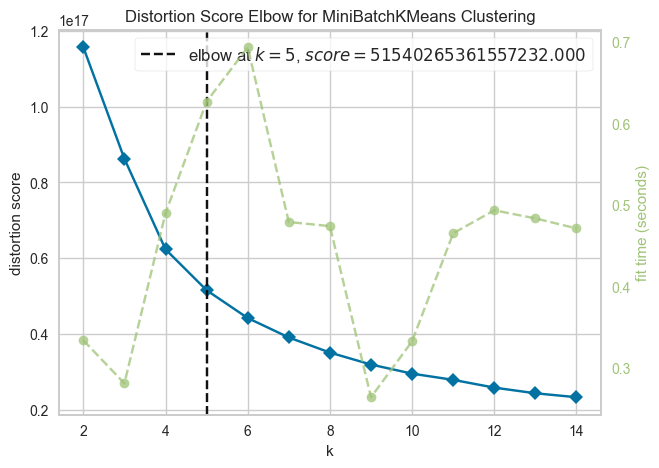

Best k (Yellowbrick): 5
Fit final K-Means, k = 5


/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/rimsj/PROJECT/COLLEGE/Machine-Learning/venv/lib/p

In [ ]:

K_MIN, K_MAX = 2, 15
use_minibatch = (X.shape[0] > 300_000)
best_k = None

if _YB_OK:
    print("KElbowVisualizer running...")
    model = MiniBatchKMeans(random_state=RANDOM_STATE) if use_minibatch else KMeans(random_state=RANDOM_STATE)
    try:
        viz = KElbowVisualizer(model, k=(K_MIN, K_MAX))
        viz.fit(X)
        best_k = int(viz.elbow_value_) if viz.elbow_value_ is not None else None
        viz.show()
        print("Best k (Yellowbrick):", best_k)
    except Exception as e:
        print("KElbowVisualizer error, fallback manual:", e)
        _YB_OK = False

if not _YB_OK:
    inertias = []
    ks = list(range(K_MIN, K_MAX+1))
    for k in ks:
        km = (MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=4096, n_init=10)
              if use_minibatch else
              KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=15))
        km.fit(X)
        inertias.append(km.inertia_)
    plt.figure()
    plt.plot(ks, inertias, marker='o')
    plt.title("Elbow Plot (Inertia vs k)")
    plt.xlabel("k"); plt.ylabel("Inertia")
    plt.tight_layout(); plt.show()
    # simple heuristic
    diffs = np.diff(inertias)
    if len(diffs) > 0:
        best_k = int(ks[np.argmin(diffs)])

if best_k is None:
    best_k = 8

print("Fit final K-Means, k =", best_k)
model_kmeans = (MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE, batch_size=4096, n_init=20)
                if use_minibatch else
                KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=25))
labels = model_kmeans.fit_predict(X)

# quick metrics
try: sil = silhouette_score(X, labels)
except: sil = np.nan
try: ch = calinski_harabasz_score(X, labels)
except: ch = np.nan
try: db = davies_bouldin_score(X, labels)
except: db = np.nan
print(f"Silhouette: {sil}, CH: {ch}, DB: {db}")

joblib.dump(model_kmeans, "model_clustering.h5")
print("Model tersimpan sebagai model_clustering.h5")



## 6) Interpretasi Kluster
Gunakan profil mean/std per fitur untuk menamai klaster.


In [ ]:

df_result = df_clean.copy()
df_result["Cluster"] = labels

print("Distribusi ukuran klaster:")
display(df_result["Cluster"].value_counts().sort_index())

if len(num_cols)>0:
    print("\nMean numerik per klaster:")
    display(df_result.groupby("Cluster")[num_cols].mean())
    print("\nStd numerik per klaster:")
    display(df_result.groupby("Cluster")[num_cols].std(ddof=0))

if len(cat_cols)>0:
    print("\nMode kategorikal per klaster:")
    rows = []
    for c in sorted(df_result["Cluster"].unique()):
        sub = df_result[df_result["Cluster"]==c]
        row = {"Cluster": c}
        for col in cat_cols:
            row[col] = sub[col].mode().iloc[0] if not sub[col].mode().empty else np.nan
        rows.append(row)
    display(pd.DataFrame(rows))

# Visualisasi sederhana: PCA 2D (jika dimensi > 2)
from sklearn.decomposition import PCA
if X.shape[1] >= 2:
    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca2.fit_transform(X)
    plt.figure(figsize=(7,5))
    for c in sorted(df_result["Cluster"].unique()):
        m = (df_result["Cluster"].values == c)
        plt.scatter(X2[m,0], X2[m,1], s=6, label=f"Cluster {c}")
    plt.title(f"PCA 2D Scatter — k={model_kmeans.n_clusters}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(markerscale=2)
    plt.tight_layout(); plt.show()



## 7) Mengekspor Data
- `clustered_data.csv`: dataset berlabel
- `cluster_centroids.csv`: centroid (numerik di-skala balik)
- model: `model_clustering.h5` (sudah disimpan)


In [ ]:

out_dir = Path("data/output")
out_dir.mkdir(parents=True, exist_ok=True)

# labeled dataset
labeled_path = out_dir / "clustered_data.csv"
df_result.to_csv(labeled_path, index=False)
print("Saved:", labeled_path)

# centroids: inverse scaling numerik (kategorikal tetap encoded)
centroids = model_kmeans.cluster_centers_
n_num = len(num_cols)
n_cat = len(cat_cols)
centroids_num = centroids[:, :n_num] if n_num>0 else np.empty((centroids.shape[0], 0))
centroids_cat = centroids[:, n_num:] if n_cat>0 else np.empty((centroids.shape[0], 0))

if n_num>0 and isinstance(scaler, (StandardScaler, MinMaxScaler)):
    centroids_num_orig = scaler.inverse_transform(centroids_num)
else:
    centroids_num_orig = centroids_num

centroids_df = pd.DataFrame(
    np.hstack([centroids_num_orig, centroids_cat]) if n_cat>0 else centroids_num_orig,
    columns = num_cols + cat_cols
)
centroids_df.insert(0, "Cluster", range(centroids_df.shape[0]))

centroids_path = out_dir / "cluster_centroids.csv"
centroids_df.to_csv(centroids_path, index=False)
print("Saved:", centroids_path)
